# Method Mages Present: 
## Home Sweet Loan: Can You Afford Your Dream Home? 

##### By: Erin Smajdek and Lenin Canio

### Introduction

&nbsp; With the rising cost of housing, it can be difficult for families and individuals to afford to own a home. With house prices and inflation seemingly increasing every year, budgeting to purchase a home seems like a daunting task.
<br>
<br>
&nbsp; There is a general rule in finance that one’s housing costs should account for no more than 33% of their household income. We are looking to estimate if one can stay within the 33% allotment given a dataset on home price and income information. We will train our model on this dataset to see what way home prices versus household income are trending in the coming years to find the affordability of owning a home in the United States.

### Data Set
Link to the dataset you want to use and a brief description (100 to 300 words)
<br>
<br>
https://www.kaggle.com/datasets/joshhaber/us-real-estate-incomepriceregion-census-data
<br>
<br>
&nbsp; We are starting with this dataset from Kaggle, which depicts the prices people paid for homes between 2014 - 2022, as well as their relationship to average income. The dataset also provides income information, adjusts for inflation, and accounts for geographical region, average sale price, number of households, median income, and mean income.
<br>
<br>
&nbsp; As with any dataset, we will need to run analysis and perform data cleaning that way, we have a reliable source to train our learning model on. Ideally, this would have been a larger sample size but we are confident that this dataset is a great starting point to train our model as it is objective and we can easily add additional data and run the inflation conversion to generate more information.


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/esmaj234/CST383_Proj/main/RealEstateUnitedStates%202.CSV')

df

,Year,Month,Region,Home Size,Average Sales Price,Number of Households (Thousands),Median Income - Current Dollars,Median Income - 2022 Dollars,Mean Income - Current Dollars,Mean Income - 2022 Dollars
0,2022,December,Midwest,Double,144300.0,28280.0,73070.0,73070.0,102400.0,102400.0
1,2022,December,Midwest,Single,82300.0,28280.0,73070.0,73070.0,102400.0,102400.0
2,2022,December,Midwest,Total1,104700.0,28280.0,73070.0,73070.0,102400.0,102400.0
3,2022,December,Northeast,Double,158300.0,22630.0,80360.0,80360.0,115300.0,115300.0
4,2022,December,Northeast,Single,75300.0,22630.0,80360.0,80360.0,115300.0,115300.0
...,...,...,...,...,...,...,...,...,...,...
1570,2014,January,United States,Single,48000.0,124600.0,53660.0,64900.0,75740.0,91610.0
1571,2014,January,United States,Total1,68300.0,124600.0,53660.0,64900.0,75740.0,91610.0
1572,2014,January,West,Double,93900.0,27910.0,57690.0,69780.0,79610.0,96300.0
1573,2014,January,West,Single,55400.0,27910.0,57690.0,69780.0,79610.0,96300.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              1575 non-null   int64  
 1   Month                             1575 non-null   object 
 2   Region                            1575 non-null   object 
 3   Home Size                         1575 non-null   object 
 4   Average Sales Price               1575 non-null   float64
 5   Number of Households (Thousands)  1575 non-null   float64
 6   Median Income - Current Dollars   1575 non-null   float64
 7   Median Income - 2022 Dollars      1575 non-null   float64
 8   Mean Income - Current Dollars     1575 non-null   float64
 9   Mean Income - 2022 Dollars        1575 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 123.2+ KB


We need to add an afforability column so we can predict if home prices will be within the predetermined 33% of household income. Accourding to Forbes, the average UF first-time home buyer puts 6% down when purchasing a home.

<br>
<br>
https://www.forbes.com/advisor/mortgages/average-down-payment-on-a-house/

In [4]:
# Function for calculating monthly mortgage payment plus property taxes and homeowners insurance given the Average Sales Price (principal)

def calculate_monthly_mortgage(principal):
    # Fixed annual interest rate (2014-2022 average)
    annual_rate = 3.95
    # Fixed loan term in years
    years = 30
    # Account for 6% down payment at time of purchase
    principal = principal * 0.94
    # Calculate monthly rate from annual rate
    monthly_rate = annual_rate / 100 / 12
    # Total number of payments
    total_payments = years * 12
    # calculate monthly payment without property taxes and insurance
    monthly_payment = principal * (monthly_rate * (1 + monthly_rate)**total_payments) / ((1 + monthly_rate)**total_payments - 1)
    # Calculate property tax component (1.16% of principal annually, divided by 12 for monthly)
    property_tax_monthly = principal * 0.0116 / 12
    # Add property tax to monthly payment
    monthly_payment_with_tax = monthly_payment + property_tax_monthly
    # Add yearly homeowners insurance cost
    homeowners_insurance_yearly = 1249
    homeowners_insurance_monthly = homeowners_insurance_yearly / 12
    # Add homeowners insurance to monthly payment
    monthly_payment_with_insurance = monthly_payment_with_tax + homeowners_insurance_monthly
    return monthly_payment_with_insurance

# Calculate Affordability directly and add it as a new column
df['Affordability'] = df.apply(lambda row: round(calculate_monthly_mortgage(row['Average Sales Price']) / (row['Median Income - Current Dollars'] / 12), 3), axis=1)

df


,Year,Month,Region,Home Size,Average Sales Price,Number of Households (Thousands),Median Income - Current Dollars,Median Income - 2022 Dollars,Mean Income - Current Dollars,Mean Income - 2022 Dollars,Affordability
0,2022,December,Midwest,Double,144300.0,28280.0,73070.0,73070.0,102400.0,102400.0,0.144
1,2022,December,Midwest,Single,82300.0,28280.0,73070.0,73070.0,102400.0,102400.0,0.090
2,2022,December,Midwest,Total1,104700.0,28280.0,73070.0,73070.0,102400.0,102400.0,0.109
3,2022,December,Northeast,Double,158300.0,22630.0,80360.0,80360.0,115300.0,115300.0,0.142
4,2022,December,Northeast,Single,75300.0,22630.0,80360.0,80360.0,115300.0,115300.0,0.076
...,...,...,...,...,...,...,...,...,...,...,...
1570,2014,January,United States,Single,48000.0,124600.0,53660.0,64900.0,75740.0,91610.0,0.081
1571,2014,January,United States,Total1,68300.0,124600.0,53660.0,64900.0,75740.0,91610.0,0.105
1572,2014,January,West,Double,93900.0,27910.0,57690.0,69780.0,79610.0,96300.0,0.127
1573,2014,January,West,Single,55400.0,27910.0,57690.0,69780.0,79610.0,96300.0,0.084


We need to create a column called "Region Number" so we can use the Region as a predictor. As well as updating the Home Size to an integer value.

In [26]:
# map regions to integers
region_to_number_mapping = {
    'Midwest': 1,
    'Northeast': 2,
    'South': 3,
    'West': 4,
    'United States': 5
}

home_size_mapping = {
    'Total1': 0,
    'Single ': 1,
    'Double': 2
}
# Notice the data is a little messy, we had to use 'Single ' (with a whitespace)

# add "Region Number" and "Home Size Number" column to dataframe
df['Region Number'] = df['Region'].replace(region_to_number_mapping)
df['Home Size Number'] = df['Home Size'].replace(home_size_mapping)

df

,Year,Month,Region,Home Size,Average Sales Price,Number of Households (Thousands),Median Income - Current Dollars,Median Income - 2022 Dollars,Mean Income - Current Dollars,Mean Income - 2022 Dollars,Affordability,Region Number,Home Size Number
0,2022,December,Midwest,Double,144300.0,28280.0,73070.0,73070.0,102400.0,102400.0,0.144,1,2
1,2022,December,Midwest,Single,82300.0,28280.0,73070.0,73070.0,102400.0,102400.0,0.090,1,1
2,2022,December,Midwest,Total1,104700.0,28280.0,73070.0,73070.0,102400.0,102400.0,0.109,1,0
3,2022,December,Northeast,Double,158300.0,22630.0,80360.0,80360.0,115300.0,115300.0,0.142,2,2
4,2022,December,Northeast,Single,75300.0,22630.0,80360.0,80360.0,115300.0,115300.0,0.076,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,2014,January,United States,Single,48000.0,124600.0,53660.0,64900.0,75740.0,91610.0,0.081,5,1
1571,2014,January,United States,Total1,68300.0,124600.0,53660.0,64900.0,75740.0,91610.0,0.105,5,0
1572,2014,January,West,Double,93900.0,27910.0,57690.0,69780.0,79610.0,96300.0,0.127,4,2
1573,2014,January,West,Single,55400.0,27910.0,57690.0,69780.0,79610.0,96300.0,0.084,4,1


 We will be using the Region, Average Sales Price, Home Size and Year as our predictors for the model. Let's take a look at some information on the columns we'll be using. Below is a matrix of graphs where we can view different behaviors when looking at our predictor columns. 

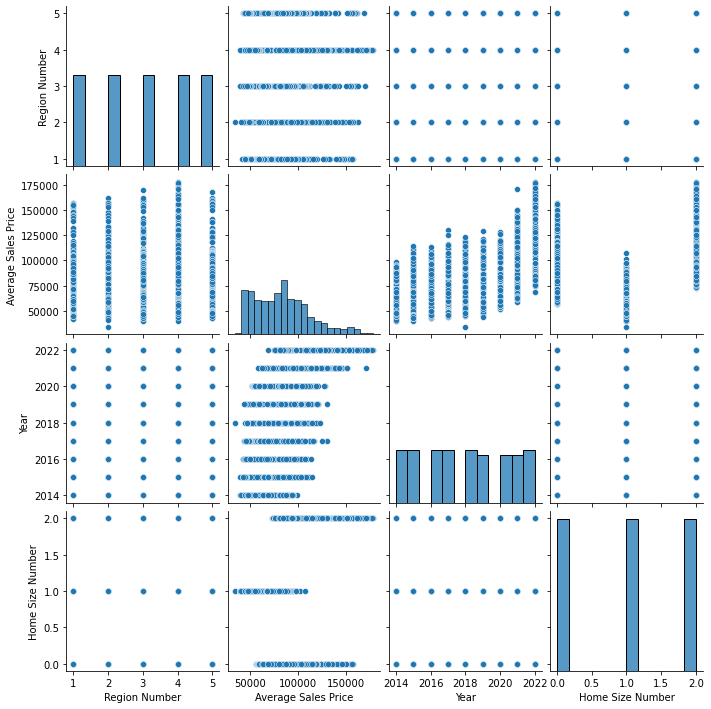

In [30]:
sns.pairplot(df[['Region Number', 'Average Sales Price', 'Year', 'Home Size Number']]);

In [46]:

predictors = ['Region Number',
              'Average Sales Price', 
              'Year',
              'Home Size Number']

target = 'Affordability'
X = df[predictors].values
y = df[target].values

In [47]:
# Split the data into training and test sets, and scale
scaler = StandardScaler()


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

Now, let's create a linear regression model to determine future home affordability!

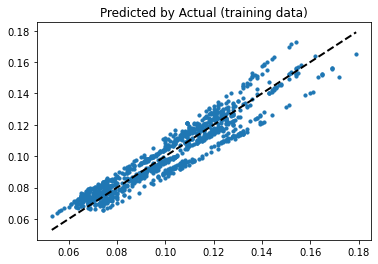

In [48]:
# Earlier in a homework assignment we created an insightful function to plot predicted vs actual values
# as well as when they are the same
def plot_actual_predicted(actual, predicted, title):
    plt.scatter(x=actual, y=predicted, s=10)
    
    minimum = min(actual.min(), predicted.min())
    
    maxium = max(actual.max(),predicted.max())
    
    plt.plot([minimum, maxium], (minimum, maxium), color='black', linewidth=2, linestyle='dashed')
    plt.title(title)
    plt.show()

# Build the model...
reg = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None)
reg.fit(X_train, y_train)

# Run the plotting function...

predicted = reg.predict(X_train)

plot_actual_predicted(y_train, predicted, 'Predicted by Actual (training data)')

Cool! Seems like our model is being trained well! Let's see what coefficients we get to figure out a formula to determine affordability over time.

In [50]:
print('intercept: {:.2f}'.format(reg.intercept_))
print('coefficient for Region Number: {:.2f}'.format(reg.coef_[0]))
print('coefficient for Average Sales Price: {:.2f}'.format(reg.coef_[1]))
print('coefficient for Year: {:.2f}'.format(reg.coef_[2]))
print('coefficient for Home Size: {:.2f}'.format(reg.coef_[3]))
print('r-squared value: {:.2f}'.format(reg.score(X_train, y_train)))

intercept: 0.10
coefficient for Region Number: 0.00
coefficient for Average Sales Price: 0.03
coefficient for Year: -0.01
coefficient for Home Size: 0.00
r-squared value: 0.90


These values mean that the region and home size has no impact on the affordability of the home. But for each dollar the average sales price goes up, the affordability percent increases by 3%. Then for each year, the affordability decreases by 1%. We can turn this into a function like this:

$$
\text{Affordability} = 0.10 + 0.03 \times \text{Average Sales Price} - 0.01 \times \text{Year}
$$

In [ ]:
plt.plot(df['Year'], df['Median Income - 2022 Dollars'])
plt.show()